In [64]:
# Base ------------------------------------------------
import numpy as np
import pandas as pd
import random as rd

# Viz -------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12,5

# Models ----------------------------------------------
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ShuffleSplit
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

In [58]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [2]:
def rand_gl(x, m, name = None, labels = None):
    '''
    Creation of a randomly generated factor series of pandas
    
    INPUT:
    x: value that determines the number of possible categories, since we begin at 0, a velue of 1 will imply 2 categories
    m: length of the vector
    name: default values of the input values: 0, 1,... The number of names cannot be in disagreement with the value of x
    labels: labels of the categories. The number of labels cannot be in disagreement with the value of x
    
    OUTPUT:
    the output is a categorical vector of length m with labels given by the names or the labels with 
    '''
    cat = []
    for i in range(m):
        cat += [rd.randint(0, x)]
    
    if name is None:
        cat = pd.Series(cat, dtype = 'category', name = 'categories')
    else:
        cat = pd.Series(cat, dtype = 'category', name = name)
    
    if labels is None:
        return(cat)
    else:
        cat = cat.cat.rename_categories(labels)
        return(cat)

In [35]:
males = pd.DataFrame({'height': np.random.normal(1.70, 2.45, 1000),
                      'weight': np.random.normal(74.2, 6.67, 1000),
                      'female': ['0']*1000,
                      'siblings': rand_gl(1, 1000, labels=['yes', 'no'])})

females = pd.DataFrame({'height': np.random.normal(1.65, 3.81, 500),
                      'weight': np.random.normal(65.5, 5.31, 500),
                      'female': ['1']*500,
                      'siblings': rand_gl(1, 500, labels=['yes', 'no'])})

mydata = pd.concat([males, females])
mydata.head(5)

,height,weight,female,siblings
0,2.532028,69.044547,0,no
1,6.554070,79.220821,0,no
2,1.349114,75.970496,0,yes
3,2.112836,69.958285,0,no
4,2.641537,80.466341,0,yes


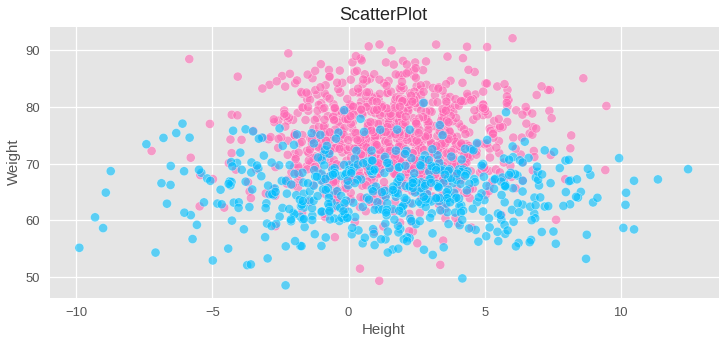

In [65]:
colors={'1': 'deepskyblue', '0': 'hotpink'}

plt.scatter(mydata['height'], mydata['weight'],
            c = mydata['female'].map(colors),
            alpha = 0.6,
            edgecolor = 'white')
plt.title('ScatterPlot', fontsize = 18)
plt.xlabel('Height', fontsize = 15)
plt.ylabel('Weight', fontsize = 15)
plt.show()

In [42]:
x_train, x_test, y_train, y_test = train_test_split(mydata[features],
                                                    mydata['female'],
                                                    test_size = 0.20,
                                                    random_state = np.random.RandomState(101),
                                                    stratify = mydata['female'])

In [45]:
# Model --------------------------------------------------
model = GaussianNB()

# Features -----------------------------------------------
features = ['height', 'weight']

# Fit the model ------------------------------------------
model.fit(x_train.values,
          y_train)

# Predictions --------------------------------------------
predictions = model.predict(x_test.values)
expected = y_test

# Output -------------------------------------------------
output = pd.DataFrame({'Prediction': predictions,
                       'True': expected})
output.head()

,Prediction,True
267,1,1
477,0,1
118,1,1
49,0,0
638,0,0


In [46]:
print('Confusion Matrix: \n', confusion_matrix(expected, predictions))

Confusion Matrix: 
 [[164  36]
 [ 37  63]]


In [47]:
print('Precision: ', metrics.precision_score(expected, predictions,  pos_label='1'))
print('Recall: ', metrics.recall_score(expected, predictions,  pos_label='1'))
print('Accuracy: ', metrics.accuracy_score(expected, predictions))

Precision:  0.6363636363636364
Recall:  0.63
Accuracy:  0.7566666666666667


In [53]:
model_probs = model.predict_proba(x_test.values)
fp, tp, thresholds = roc_curve(y_test, model_probs[:,1], pos_label='1')
prec, rec, _ = precision_recall_curve(y_test, model_probs[:,1], pos_label='1')

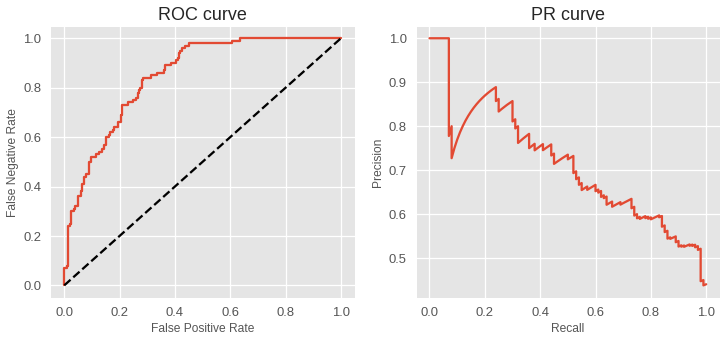

In [66]:
plt.subplot(1,2,1)
plt.plot(fp, tp)
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('False Negative Rate', fontsize = 12)

plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.title('PR curve', fontsize = 18)
plt.ylabel('Precision', fontsize = 12)
plt.xlabel('Recall', fontsize = 12)

plt.show()

In [71]:
param_range=np.logspace(-9, -1, 10)
train_scores, test_scores = validation_curve(model,
                                             mydata[features],
                                             mydata['female'],
                                             n_jobs=4,
                                             scoring='accuracy',
                                             param_range=param_range,
                                             param_name='var_smoothing')

In [80]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

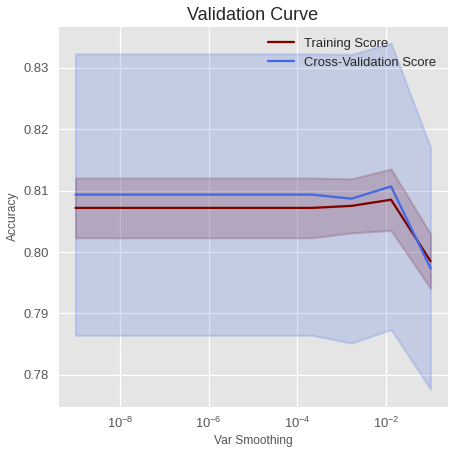

In [81]:
plt.figure(figsize = (7,7))
plt.semilogx(param_range, train_scores_mean, label='Training Score', color='maroon')
plt.fill_between(param_range, 
                 train_scores_mean-train_scores_std,
                 train_scores_mean+train_scores_std,
                 alpha=0.2,
                 color='maroon',
                 lw=2)
plt.semilogx(param_range, test_scores_mean, label='Cross-Validation Score', color='RoyalBlue')
plt.fill_between(param_range, 
                 test_scores_mean-test_scores_std,
                 test_scores_mean+test_scores_std,
                 alpha=0.2,
                 color='royalblue',
                 lw=2)

plt.title('Validation Curve', fontsize=18)
plt.xlabel('Var Smoothing', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.legend(loc='best')
plt.show()

In [95]:
train_size, train_score, test_score, fit_times, _ = learning_curve(model,
                                                                   mydata[features],
                                                                   mydata['female'],
                                                                   n_jobs = 4,
                                                                   cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0),
                                                                   train_sizes = np.linspace(.1, 1.0, 10),
                                                                   return_times = True)

In [96]:
train_scores_mean = np.mean(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
fit_time_mean = np.mean(fit_times, axis=1)

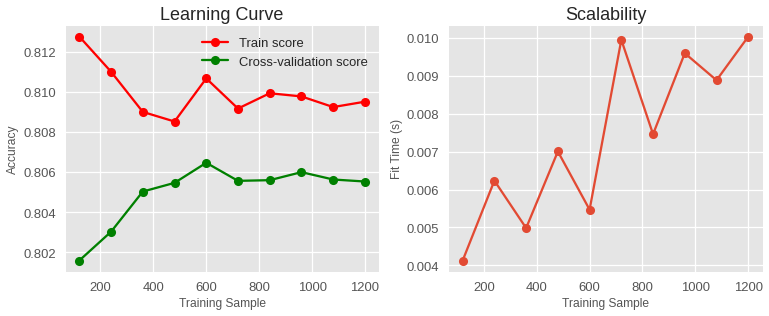

In [97]:
plt.subplot(1,2,1)
plt.plot(train_size, train_scores_mean, 'o-', label='Train score', color="red")
plt.plot(train_size, test_scores_mean, 'o-', label='Cross-validation score', color="green")
plt.legend(loc='best')
plt.title('Learning Curve', fontsize=18)
plt.xlabel('Training Sample', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.subplot(1,2,2)
plt.plot(train_size,
         fit_time_mean, 'o-')
plt.title('Scalability', fontsize=18)
plt.xlabel('Training Sample', fontsize=12)
plt.ylabel('Fit Time (s)', fontsize=12)

plt.tight_layout(rect=(0,0,0.9,0.9))
plt.show()